<a href="https://colab.research.google.com/github/armarmarm927/dl_lecture_competition_pub/blob/main/sparkproto17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomAffine([-10,10],scale=(1,1.25)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomErasing(p=0.5,scale=(0.02,0.33),ratio=(0.3,3.3),value=0,inplace=False)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

100%|██████████| 170M/170M [00:12<00:00, 13.1MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
model_ft = models.resnet50(pretrained=True)
model_ft.fc = nn.Linear(model_ft.fc.in_features, 10)
net = model_ft.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 160MB/s]


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [8]:
num_epochs = 70
loss_list = []
acc_list = []
train_acc_list = []

for epoch in range(num_epochs):
    net.train()
    correct_train = 0
    total_train = 0
    epoch_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = 100. * correct_train / total_train
    train_acc_list.append(train_accuracy)
    print(f'Epoch {epoch+1}: Loss: {epoch_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%')
    loss_list.append(epoch_loss/len(train_loader))

    net.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    test_accuracy = 100. * correct / total
    acc_list.append(test_accuracy)
    print(f'Test Accuracy: {test_accuracy:.2f}%')

    # 混同行列の出力
    cm = confusion_matrix(y_true, y_pred)
    print(f'Confusion Matrix (Epoch {epoch+1}):')
    print(cm)

    torch.save(net.state_dict(), '/content/drive/MyDrive/Weight_Epoch50.pth')
    scheduler.step()

Epoch 1: Loss: 1.3691, Train Accuracy: 52.42%
Test Accuracy: 64.69%
Confusion Matrix (Epoch 1):
[[783  25  74   3   3   2   3   6  74  27]
 [ 28 865   5   3   0   6   4   1  61  27]
 [106  20 669  17  49  76  32   9  17   5]
 [ 34  31 182 351  38 229  80  28  13  14]
 [ 66   8 191  41 506  25  35  95  27   6]
 [ 14  16 134  87  30 678  19  13   3   6]
 [  5  20 165  47  50  32 671   1   9   0]
 [ 54  28 127  29  68  84  14 541   9  46]
 [112  24  10  10   1   7   5   0 822   9]
 [ 58 253   6   1   4   5  22   0  68 583]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2: Loss: 1.0746, Train Accuracy: 63.16%
Test Accuracy: 73.39%
Confusion Matrix (Epoch 2):
[[781  22  31  12  36   4   2  12  71  29]
 [ 21 809  12  11   1  14   4   3  25 100]
 [ 69   0 574  20 180  72  53  24   7   1]
 [ 27   2  57 413 134 238  62  51   7   9]
 [ 15   2  27  15 846  20  27  42   6   0]
 [ 12   0  41  78  88 701  12  66   2   0]
 [  4   3  46  44  83  29 780   8   3   0]
 [ 21   1  33  12  95  47   5 779   1   6]
 [ 50  26  12  17  12   5   4   9 854  11]
 [ 40  61  14  15   6   8   8  24  22 802]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3: Loss: 1.0421, Train Accuracy: 64.20%
Test Accuracy: 68.81%
Confusion Matrix (Epoch 3):
[[565  43  83   3  14   1   5  12 196  78]
 [  4 922   1   0   0   4   0   1  28  40]
 [ 41  31 619  27  96  71  34  43  24  14]
 [ 22  44  78 449  54 198  38  59  23  35]
 [ 28  20  63  34 620  40  26 128  20  21]
 [  7  34  39  89  38 686   7  64  11  25]
 [  4  77  54  76  40  43 654  10  22  20]
 [ 13  24  31  27  40  50   3 745  10  57]
 [ 19  36  11   3   3   4   0   2 904  18]
 [  7 218   4   1   0   3   0   4  46 717]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4: Loss: 0.9297, Train Accuracy: 67.90%
Test Accuracy: 75.90%
Confusion Matrix (Epoch 4):
[[901  13  19   6   6   2   1   8  25  19]
 [ 38 903  13   2   2   1   0   1  10  30]
 [101   1 722  24  70  25  17  29  10   1]
 [ 50   2 103 577  53 136  14  44   6  15]
 [ 36   1  68  32 762  17  13  65   6   0]
 [ 21   1 108 130  42 617   7  67   4   3]
 [ 15   5 114  77  71  14 690   9   4   1]
 [ 31   4  35  26  35  23   3 831   1  11]
 [113  26  13   5   3   0   0   4 824  12]
 [ 76 112   4   7   3   2   2   9  22 763]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5: Loss: 0.9472, Train Accuracy: 67.16%
Test Accuracy: 74.43%
Confusion Matrix (Epoch 5):
[[737  34  49  13   8   4  11   9 121  14]
 [  7 939   3   1   1   3   2   4  21  19]
 [ 54  10 618  51  52 103  73  21  15   3]
 [ 23  14  52 566  28 198  59  30  17  13]
 [ 18   9  57  56 658  44  67  63  23   5]
 [  6  12  33 132  28 716  13  49   6   5]
 [  8  11  30  53   9  24 851   3   5   6]
 [ 19   3  21  34  54  77  13 759   8  12]
 [ 39  30   7   7   1   8   2   2 900   4]
 [ 22 187   6   9   0   5   2  12  58 699]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6: Loss: 0.9737, Train Accuracy: 66.56%
Test Accuracy: 77.18%
Confusion Matrix (Epoch 6):
[[789  28  37  18   8   2   3  10  84  21]
 [ 11 889   3   7   0   4   0   3  22  61]
 [ 50   4 645  57  74  94  30  24  15   7]
 [ 15   4  34 624  42 196  29  29  18   9]
 [ 17   1  42  59 756  34  29  41  18   3]
 [  3   0  19 154  34 740   9  26  11   4]
 [  6   4  48  66  20  32 806   5   9   4]
 [ 20   0  19  41  49  93   4 753   7  14]
 [ 53  20   7   7   1   3   0   2 896  11]
 [ 35  77   4  15   0   5   2   9  33 820]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7: Loss: 0.8122, Train Accuracy: 72.00%
Test Accuracy: 73.43%
Confusion Matrix (Epoch 7):
[[879   7  15   9  20   2   3   2  48  15]
 [ 34 825   5   6   0   2  13   1  46  68]
 [ 87   0 648  68  97  34  47  11   6   2]
 [ 28   3  44 686  74  64  67  18   8   8]
 [ 21   1  46  31 819  10  64   5   3   0]
 [  9   0  56 251  59 575  25  13   8   4]
 [ 14   0  49  58  19  10 847   0   2   1]
 [ 43   2  37  85 309  76  18 415   1  14]
 [104   5  17  12   3   0   4   3 848   4]
 [ 54  56   3  24   1   2   8   4  47 801]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8: Loss: 0.8189, Train Accuracy: 71.63%
Test Accuracy: 78.30%
Confusion Matrix (Epoch 8):
[[868  11  10   2   7   1   2   6  78  15]
 [ 20 915   2   3   2   4   1   0  21  32]
 [ 86   2 750  19  41  43  18  25  12   4]
 [ 36   5  78 493  55 228  22  32  33  18]
 [ 32   2  97  28 743  34  21  30  12   1]
 [ 15   2  42  89  46 744   3  37  19   3]
 [ 14   5  65  38  20  47 781  14  12   4]
 [ 35   5  26  16  49  44   1 805   8  11]
 [ 49  14   4   4   1   3   0   1 919   5]
 [ 46  80   1   4   0   4   1   5  47 812]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 9: Loss: 0.7484, Train Accuracy: 74.07%
Test Accuracy: 80.09%
Confusion Matrix (Epoch 9):
[[843   8  46   4  12   3   1   8  48  27]
 [  9 881   3   1   0   1   0   7  37  61]
 [ 42   2 735  15  92  47  31  22  10   4]
 [ 18   2  44 427  89 313  33  47  17  10]
 [ 26   1  28   9 851  20  12  39  12   2]
 [ 10   1  24  43  52 805  11  41   8   5]
 [  7   3  27  18  45  41 838  11   7   3]
 [ 25   4  12   9  37  44   4 855   2   8]
 [ 57   7   7   3   5   3   0   2 905  11]
 [ 32  38   2   9   1   2   1  12  34 869]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10: Loss: 0.7266, Train Accuracy: 74.83%
Test Accuracy: 78.84%
Confusion Matrix (Epoch 10):
[[808   6  27   5  26   2   8  17  85  16]
 [ 15 842   8   8   3   5   9  11  58  41]
 [ 50   0 760  15  66  28  33  40   7   1]
 [ 22   1  90 558  74 122  37  81   9   6]
 [  7   0  52  17 796  13  32  78   5   0]
 [  8   0  60 122  44 643  16 104   1   2]
 [  8   0  49  32  26  13 850  20   2   0]
 [ 15   0   7  12  29  14   3 914   0   6]
 [ 33   5  10   4   9   2   2   8 923   4]
 [ 31  45   3  10   7   7   5  32  70 790]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 11: Loss: 1.1743, Train Accuracy: 59.72%
Test Accuracy: 48.33%
Confusion Matrix (Epoch 11):
[[617  49  64  11   4  31  11  32 152  29]
 [ 50 690   2  10   2   4  17  29  64 132]
 [ 76  40 310  44 110 136 134 108  27  15]
 [ 52  78  89 162  36 302 102 139  17  23]
 [ 52  37 103  28 308  78 149 199  33  13]
 [ 38  42 125  86  42 422  40 187  12   6]
 [ 20  74  54  44  48  51 601  83   8  17]
 [ 52  26  63  35  57  85  32 606  13  31]
 [184  75  12   9   4  14   4  14 653  31]
 [ 74 266   9   4   2   3  27  52  99 464]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 12: Loss: 1.4793, Train Accuracy: 47.41%
Test Accuracy: 64.86%
Confusion Matrix (Epoch 12):
[[733  22  51  15   5   2   6  19 108  39]
 [ 25 774   4   3   0   8   4   4  55 123]
 [ 85  14 563  60  50  71  86  32  23  16]
 [ 24  14 112 376  51 243  94  31  35  20]
 [ 34   9 153  47 468  53  97  99  35   5]
 [ 17   9  97 178  32 586  25  42   7   7]
 [  7  10 111  60  28  30 735   5   9   5]
 [ 28   6  80  47  68  92   9 638   3  29]
 [ 62  31   6   5   1   2   7   2 867  17]
 [ 54 115   4   7   2   4   7  20  41 746]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 13: Loss: 1.1426, Train Accuracy: 60.06%
Test Accuracy: 72.29%
Confusion Matrix (Epoch 13):
[[793  11  28   9   8   6   8  15  99  23]
 [ 35 847  10   2   0   8   6   6  50  36]
 [ 76   3 627  32  72  77  69  30  11   3]
 [ 31   4  90 489  49 194  75  43  14  11]
 [ 21   2  84  25 614  59  55 116  20   4]
 [ 15   3  73 144  28 665  19  45   7   1]
 [  8   6  56  47  31  49 791   7   4   1]
 [ 26   4  46  27  37 100   7 741   3   9]
 [ 39  15  12   4   4   5   2   2 910   7]
 [ 45  98   8   7   6   7   6  14  57 752]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 14: Loss: 0.9659, Train Accuracy: 66.50%
Test Accuracy: 76.09%
Confusion Matrix (Epoch 14):
[[841  10  10   9   7   3   3   5  74  38]
 [ 31 853   8   3   3   4   1   1  37  59]
 [128   0 601  40  69  63  57  28   8   6]
 [ 36  11  39 535  60 185  53  44  17  20]
 [ 27   1  66  25 764  27  38  38  12   2]
 [ 15   5  45 100  41 717  13  52   7   5]
 [ 16   6  59  42  46  29 774  12  13   3]
 [ 39   2  19  14  77  58   3 771   5  12]
 [ 48  16   7   7   2   1   0   4 904  11]
 [ 34  70   1   2   6   4   0   5  29 849]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 15: Loss: 0.8287, Train Accuracy: 71.24%
Test Accuracy: 78.99%
Confusion Matrix (Epoch 15):
[[850  18  25  17   8   6   4  12  36  24]
 [ 17 940   3   6   1   6   0   2   5  20]
 [ 63   1 728  43  49  43  48  16   3   6]
 [ 19   5  61 643  33 144  52  31   2  10]
 [ 12   2  75  42 762  27  46  30   3   1]
 [ 10   1  64 151  25 703  15  24   4   3]
 [  6   6  43  47  12  23 857   2   3   1]
 [ 25   4  29  36  48  71   6 771   1   9]
 [ 76  31  15  12   3   2   0   3 849   9]
 [ 29 128   4   8   2  11   2   5  15 796]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 16: Loss: 0.8050, Train Accuracy: 71.94%
Test Accuracy: 79.53%
Confusion Matrix (Epoch 16):
[[863  19  16   6  12   1   3  11  58  11]
 [ 18 921   2   2   0   5   2   3  16  31]
 [ 76   0 690  18  57  35  79  33   9   3]
 [ 34   8  48 529  61 160  76  67  11   6]
 [ 17   1  34  23 771  15  52  81   6   0]
 [  9   3  32  91  46 722  30  58   7   2]
 [ 14   5  22  27  16  15 886   7   6   2]
 [ 23   1  14  10  26  32   8 878   1   7]
 [ 49  18   4   2   3   2   3   5 909   5]
 [ 48 108   1   9   1   4   2  11  32 784]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 17: Loss: 0.7536, Train Accuracy: 73.95%
Test Accuracy: 79.66%
Confusion Matrix (Epoch 17):
[[854  17  36  10   7   0   4   3  57  12]
 [ 18 925   5   3   1   6   1   0  13  28]
 [ 42   3 803  36  34  20  47   7   4   4]
 [ 29   6  70 637  33 126  55  16  17  11]
 [ 15   1  85  47 741  22  59  19   8   3]
 [ 12   0  74 164  27 673  18  22   8   2]
 [  5   6  47  49  13  11 861   2   6   0]
 [ 26   2  44  27  59  57   1 762   6  16]
 [ 55  20  12   6   1   1   3   0 894   8]
 [ 49  91   6   4   1   4   1   0  28 816]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 18: Loss: 0.6876, Train Accuracy: 76.14%
Test Accuracy: 81.33%
Confusion Matrix (Epoch 18):
[[886  20   7  12   4   3   7   9  21  31]
 [  7 895   3   8   0   7   6   0   9  65]
 [ 69   1 694  39  71  47  48  26   2   3]
 [ 22   2  30 593  52 218  40  23   5  15]
 [ 19   1  29  39 849  23  15  20   4   1]
 [ 13   1  14  97  37 791  10  32   3   2]
 [  6   1  18  37  26  27 878   4   2   1]
 [ 22   2   7  24  55  63   4 804   4  15]
 [ 89  24   5  11   1   3   0   1 845  21]
 [ 21  37   1  16   0   3   4   4  16 898]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 19: Loss: 0.6687, Train Accuracy: 76.63%
Test Accuracy: 82.31%
Confusion Matrix (Epoch 19):
[[864  12  24  12  11   1   5   8  50  13]
 [ 12 920   1   2   1   2   4   0  27  31]
 [ 47   2 709  39  80  44  48  23   5   3]
 [ 19   8  32 659  52 125  49  28  14  14]
 [ 10   1  27  28 871  13  22  21   6   1]
 [ 12   2  27 147  38 708  17  37   4   8]
 [  6   2  15  43  30  17 876   5   5   1]
 [ 18   4  10  21  47  29   4 854   4   9]
 [ 46  10   2   7   1   2   0   0 920  12]
 [ 34  73   1   7   0   2   3   4  26 850]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 20: Loss: 0.7287, Train Accuracy: 74.92%
Test Accuracy: 60.79%
Confusion Matrix (Epoch 20):
[[890  20  19   0   3   0   2   6  52   8]
 [ 87 831  13   2   1   0   0   6  36  24]
 [138  27 691   8  72   7   7  25  24   1]
 [177  17 212 264  93  82  13 113  22   7]
 [ 75   3 116  18 682  16  11  61  16   2]
 [ 84  17 206  57  59 447  13  97  17   3]
 [123  44 237  96 204  24 170  53  43   6]
 [ 82   7  64   6  82  14   6 725  12   2]
 [140  23  12   1   5   0   0   4 809   6]
 [166 160   9   0   5   3   0  26  61 570]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 21: Loss: 0.7194, Train Accuracy: 74.97%
Test Accuracy: 81.47%
Confusion Matrix (Epoch 21):
[[799  23  41  14  13   3   5   6  54  42]
 [  5 935   4   3   1   7   2   0   7  36]
 [ 26   1 787  30  38  57  41  12   2   6]
 [  9   6  33 534  44 287  36  26   6  19]
 [  6   1  44  23 801  52  43  20   7   3]
 [  7   2  22  65  30 835   8  23   4   4]
 [  4   2  33  38  15  55 847   3   1   2]
 [  9   5  24  16  30  61   2 835   3  15]
 [ 38  21   9   9   1   4   2   1 894  21]
 [ 10  73   2   4   0  12   1   2  16 880]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 22: Loss: 0.6545, Train Accuracy: 77.64%
Test Accuracy: 71.63%
Confusion Matrix (Epoch 22):
[[873  11  51   8  11   0   5   3  36   2]
 [111 767  51  22   4   1   2   2  38   2]
 [ 72   3 777  29  67   8  26  10   6   2]
 [ 56   9 123 628  33  77  29  26  13   6]
 [ 32   8  51  44 766  12  33  51   3   0]
 [ 30   3 149 162  43 535  16  53   7   2]
 [ 14  24  66  97  41  16 728   7   5   2]
 [ 37   9  56  28  36  11   1 817   5   0]
 [130  18  26  10   0   0   3   2 811   0]
 [151 298  16  22   2   2   3  12  33 461]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 23: Loss: 0.8456, Train Accuracy: 71.50%
Test Accuracy: 80.21%
Confusion Matrix (Epoch 23):
[[854  18  35   3   4   0   5   6  56  19]
 [ 15 918   3   1   0   1   5   1  30  26]
 [ 46   3 815  11  38  14  39  21   6   7]
 [ 46   9 102 521  51 121  84  40  12  14]
 [ 15   2  69  17 790   8  62  31   5   1]
 [ 18   2  75  92  48 670  32  54   5   4]
 [  6   5  53  21   7   7 889   6   6   0]
 [ 19   4  23  13  35  18   6 873   3   6]
 [ 50  15   7   3   0   0   1   0 921   3]
 [ 32 145   4   3   1   2   2   8  33 770]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 24: Loss: 0.6647, Train Accuracy: 76.93%
Test Accuracy: 81.95%
Confusion Matrix (Epoch 24):
[[901  16  25   5   6   0   1   9  26  11]
 [ 14 939   3   3   0   3   3   3  10  22]
 [ 51   2 778  27  46  41  23  24   2   6]
 [ 31   5  38 617  41 164  43  46   9   6]
 [ 17   2  53  28 790  26  36  45   3   0]
 [ 11   3  20 112  29 768  12  39   6   0]
 [ 13   3  57  33  10  22 850   8   2   2]
 [ 16   3   9  14  28  41   5 877   2   5]
 [ 81  27   4   5   5   1   2   2 862  11]
 [ 44 107   2   6   2   2   1   7  16 813]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 25: Loss: 0.8855, Train Accuracy: 69.97%
Test Accuracy: 75.85%
Confusion Matrix (Epoch 25):
[[788   7  29   8   4   1   9  12 129  13]
 [ 44 744   0   0   0   2   5   2 140  63]
 [ 61   8 738  16  38  35  52  14  32   6]
 [ 23  11  61 487  49 185  88  40  43  13]
 [ 17   3  75  26 725  26  64  37  23   4]
 [ 10   9  49  86  37 716  34  37  18   4]
 [  8  10  57  28  16  22 837   5  16   1]
 [ 30   4  20  19  36  50   9 820   5   7]
 [ 51   1   8   5   4   7   1   7 911   5]
 [ 50  50   4   7   0   2   4  12  52 819]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 26: Loss: 0.7084, Train Accuracy: 75.56%
Test Accuracy: 83.11%
Confusion Matrix (Epoch 26):
[[845   9  27  12   5   0   5   7  61  29]
 [  6 909   5   3   0   6   3   1  25  42]
 [ 40   2 816  25  31  24  34  15   7   6]
 [ 13   1  42 676  29 143  35  41   7  13]
 [  9   1  52  44 800  21  36  32   3   2]
 [  7   1  39 115  26 745  20  38   4   5]
 [  4   5  37  56  11  16 861   7   3   0]
 [ 23   0  20  14  35  28   0 866   3  11]
 [ 49  11   9   8   3   2   1   2 911   4]
 [ 19  64   3   5   0   5   2   3  17 882]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 27: Loss: 0.6181, Train Accuracy: 78.42%
Test Accuracy: 83.20%
Confusion Matrix (Epoch 27):
[[850  11  23  10   9   3   6   9  59  20]
 [  5 936   6   2   0   4   4   2   8  33]
 [ 39   1 813  25  47  21  33  12   7   2]
 [ 14   6  75 639  51 130  45  19  12   9]
 [  5   1  49  23 850  13  32  25   2   0]
 [  6   1  44 132  47 717  19  29   3   2]
 [  4   5  33  33  25   8 885   4   3   0]
 [ 11   2  25  27  41  21   0 864   2   7]
 [ 45  24   8   7   3   1   2   3 901   6]
 [ 19  63   4   8   0   5   3   5  28 865]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 28: Loss: 0.6078, Train Accuracy: 78.83%
Test Accuracy: 83.45%
Confusion Matrix (Epoch 28):
[[830   9  32  13   6   4   6   7  66  27]
 [  7 888   7   8   0   3   3   4  33  47]
 [ 28   1 828  29  42  27  26  12   5   2]
 [ 12   2  51 706  34 116  35  26   9   9]
 [  4   1  48  38 832  18  36  19   4   0]
 [  5   0  44 141  37 737   9  20   2   5]
 [  5   3  45  57  10  10 863   3   4   0]
 [ 12   1  23  22  47  39   0 847   3   6]
 [ 37   8  12   3   4   2   0   2 923   9]
 [ 20  51   4   7   0   1   1   4  21 891]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 29: Loss: 0.5876, Train Accuracy: 79.45%
Test Accuracy: 82.61%
Confusion Matrix (Epoch 29):
[[940  11  12   3   5   0   3   4   9  13]
 [ 14 949   2   1   0   2   4   0   3  25]
 [ 66   2 769  45  39  26  30  15   3   5]
 [ 35  11  29 685  33 143  37  11   7   9]
 [ 18   1  46  36 811  26  32  24   5   1]
 [ 17   3  30 135  32 745  12  17   4   5]
 [  5   5  40  51  15  10 868   4   1   1]
 [ 17   5  12  35  31  55   2 835   2   6]
 [131  17   7   8   3   1   2   0 817  14]
 [ 49  81   7   4   1   3   1   3   9 842]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 30: Loss: 0.5725, Train Accuracy: 79.98%
Test Accuracy: 83.20%
Confusion Matrix (Epoch 30):
[[909  13  26   5   8   2   4   3  26   4]
 [ 19 946   6   1   0   2   1   2   5  18]
 [ 37   2 853  14  30  21  30   9   3   1]
 [ 30  14  95 591  53 125  45  32  10   5]
 [ 12   1  75  12 831  12  24  28   5   0]
 [ 17   2  61 103  28 729  18  39   2   1]
 [  8   7  42  32  19   8 877   5   2   0]
 [ 19   2  36  10  28  18   2 883   0   2]
 [ 55  27  10   2   2   2   2   2 896   2]
 [ 64  76   8   6   0   4   1   7  29 805]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 31: Loss: 0.5077, Train Accuracy: 82.50%
Test Accuracy: 85.98%
Confusion Matrix (Epoch 31):
[[903  10  19  10   5   0   5   7  30  11]
 [ 11 931   3   2   0   4   2   2  14  31]
 [ 37   1 826  24  38  23  35  11   3   2]
 [ 16   6  38 703  39 130  26  28   7   7]
 [  8   1  38  28 852  14  27  27   5   0]
 [  8   2  26 109  30 779  12  28   3   3]
 [  7   3  32  36  15  12 890   3   2   0]
 [ 10   3  14  12  27  18   1 906   0   9]
 [ 43  14   6   7   0   1   0   1 916  12]
 [ 26  47   4   4   0   4   1   4  18 892]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 32: Loss: 0.4812, Train Accuracy: 83.17%
Test Accuracy: 86.06%
Confusion Matrix (Epoch 32):
[[903   8  17   8   4   0   3   5  37  15]
 [ 11 930   2   4   0   3   2   1  14  33]
 [ 43   1 833  28  37  21  22  11   2   2]
 [ 21   1  40 726  35 115  21  25   6  10]
 [  9   1  36  34 845  15  23  34   3   0]
 [  8   1  27 122  29 781   7  20   3   2]
 [  9   3  31  41  17  13 879   5   2   0]
 [ 13   1  12  21  24  22   1 898   1   7]
 [ 45   8   7   7   1   1   0   1 922   8]
 [ 26  49   4   6   0   3   2   2  19 889]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 33: Loss: 0.4721, Train Accuracy: 83.35%
Test Accuracy: 86.22%
Confusion Matrix (Epoch 33):
[[908   8  21   6   7   0   3   5  31  11]
 [ 12 934   2   3   0   2   4   1  11  31]
 [ 35   1 835  25  40  23  25  12   2   2]
 [ 19   4  43 708  39 125  24  22   9   7]
 [  7   1  33  34 853  13  26  29   4   0]
 [  8   2  25 117  30 783   8  22   5   0]
 [  7   4  30  38  14  13 889   3   2   0]
 [ 10   2  12  15  26  20   1 907   1   6]
 [ 41   8   9   4   2   1   0   1 925   9]
 [ 26  61   3   4   0   3   1   4  18 880]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 34: Loss: 0.4683, Train Accuracy: 83.52%
Test Accuracy: 86.45%
Confusion Matrix (Epoch 34):
[[907   9  19   9   6   0   3   4  33  10]
 [ 13 937   2   2   0   4   3   0   7  32]
 [ 40   1 819  24  50  24  26  13   1   2]
 [ 15   3  41 704  40 136  26  18   8   9]
 [  7   1  29  28 868  12  25  25   5   0]
 [  9   2  21 110  34 795  10  15   3   1]
 [  8   4  24  35  14  11 898   3   3   0]
 [ 11   2   8  21  30  20   1 899   1   7]
 [ 47   8   4   4   2   1   0   1 925   8]
 [ 27  45   4   5   0   3   1   2  20 893]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 35: Loss: 0.4615, Train Accuracy: 83.87%
Test Accuracy: 86.34%
Confusion Matrix (Epoch 35):
[[896   8  22   9   7   0   3   5  33  17]
 [ 12 932   1   4   0   3   3   0  12  33]
 [ 37   1 832  27  37  22  26  13   2   3]
 [ 16   4  36 738  34 119  22  20   6   5]
 [  6   1  33  33 853  15  25  29   5   0]
 [  8   2  24 121  29 783   9  20   4   0]
 [  9   2  37  40  13  11 882   2   4   0]
 [ 10   2  11  19  26  20   1 903   1   7]
 [ 43   9   6   6   1   1   0   1 925   8]
 [ 25  51   4   6   0   3   0   1  20 890]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 36: Loss: 0.4576, Train Accuracy: 84.03%
Test Accuracy: 86.46%
Confusion Matrix (Epoch 36):
[[913   7  22   5   3   0   4   5  32   9]
 [ 12 935   1   3   0   3   3   0  13  30]
 [ 34   0 854  22  34  16  26  11   1   2]
 [ 20   4  43 707  33 129  24  24   9   7]
 [ 10   1  41  35 836  15  23  34   5   0]
 [  9   2  25 109  29 791   7  23   3   2]
 [  7   4  33  37   9  10 894   4   2   0]
 [  9   2  10  15  24  19   1 913   0   7]
 [ 47   8   6   4   2   1   0   1 924   7]
 [ 30  56   5   4   0   2   0   3  21 879]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 37: Loss: 0.4515, Train Accuracy: 84.16%
Test Accuracy: 86.52%
Confusion Matrix (Epoch 37):
[[896   9  21   6   6   0   4   4  37  17]
 [ 10 936   2   4   0   3   3   0   9  33]
 [ 36   1 852  19  38  16  22  13   1   2]
 [ 15   3  45 703  39 136  25  20   6   8]
 [  7   1  39  26 854  14  25  30   4   0]
 [  7   1  28 113  33 783  10  21   3   1]
 [  8   3  28  34  10  12 900   2   3   0]
 [  8   2  10  18  28  18   1 905   2   8]
 [ 40  11   7   6   2   1   0   1 922  10]
 [ 23  46   3   4   0   4   0   3  16 901]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 38: Loss: 0.4458, Train Accuracy: 84.31%
Test Accuracy: 86.79%
Confusion Matrix (Epoch 38):
[[918   5  14   6   4   0   2   6  33  12]
 [ 11 941   1   4   0   3   3   1   9  27]
 [ 44   1 840  24  33  25  18  13   0   2]
 [ 16   3  30 741  29 124  21  23   5   8]
 [  9   1  38  36 843  17  24  29   3   0]
 [  8   1  19 121  26 795   9  18   3   0]
 [  9   4  32  39   9  11 891   3   2   0]
 [ 11   1   7  17  27  24   1 907   0   5]
 [ 49  13   3   6   1   1   0   1 917   9]
 [ 28  53   4   4   0   2   1   4  18 886]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 39: Loss: 0.4395, Train Accuracy: 84.51%
Test Accuracy: 86.75%
Confusion Matrix (Epoch 39):
[[911   9  24   5   6   0   2   5  25  13]
 [  8 940   2   4   0   3   3   2   9  29]
 [ 36   1 854  18  34  19  26   9   1   2]
 [ 14   5  41 719  40 115  29  22   7   8]
 [  7   1  41  29 855  13  24  26   4   0]
 [  7   2  29 120  30 781  12  15   4   0]
 [  7   3  30  31  12   9 904   2   2   0]
 [  8   1  11  19  28  22   1 905   0   5]
 [ 48  11   5   6   2   1   0   1 916  10]
 [ 24  54   4   5   0   2   2   3  16 890]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 40: Loss: 0.4376, Train Accuracy: 84.67%
Test Accuracy: 86.71%
Confusion Matrix (Epoch 40):
[[893   9  23   5  10   0   4   4  35  17]
 [  6 937   1   3   0   4   3   1  11  34]
 [ 34   1 845  22  38  18  28   9   3   2]
 [ 15   7  35 718  38 124  26  22   7   8]
 [  7   1  34  27 863  15  25  25   3   0]
 [  8   1  24 118  27 791  11  16   4   0]
 [  7   3  29  31  13  13 899   3   2   0]
 [ 11   2  11  17  30  18   1 903   1   6]
 [ 39  13   4   7   2   1   0   1 926   7]
 [ 22  50   4   5   0   2   1   3  17 896]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 41: Loss: 0.4321, Train Accuracy: 84.86%
Test Accuracy: 86.96%
Confusion Matrix (Epoch 41):
[[923   5  26   5   5   0   3   6  18   9]
 [ 14 931   2   5   0   3   3   0  11  31]
 [ 32   0 855  20  35  23  22  10   0   3]
 [ 17   1  39 728  29 133  22  20   5   6]
 [  7   1  37  29 859  17  23  24   3   0]
 [  7   1  21 110  25 806  10  16   4   0]
 [  8   2  31  31  13  13 896   3   2   1]
 [ 11   2  12  17  32  18   1 900   0   7]
 [ 62  10   4   7   2   1   0   1 904   9]
 [ 31  44   4   5   0   2   2   2  16 894]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 42: Loss: 0.4299, Train Accuracy: 84.83%
Test Accuracy: 86.97%
Confusion Matrix (Epoch 42):
[[921   6  17   7   7   0   2   5  25  10]
 [ 10 945   5   4   0   0   3   0  11  22]
 [ 41   1 843  23  33  14  28  13   1   3]
 [ 13   4  34 762  35  94  25  20   7   6]
 [  8   1  34  31 865   9  26  24   2   0]
 [  7   2  24 143  30 756  14  19   5   0]
 [  7   3  29  34   8   7 909   1   2   0]
 [ 14   2   8  22  31  18   1 898   0   6]
 [ 46  12   2   5   2   1   0   1 922   9]
 [ 27  63   4   5   0   2   2   3  18 876]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 43: Loss: 0.4251, Train Accuracy: 84.98%
Test Accuracy: 86.96%
Confusion Matrix (Epoch 43):
[[908   6  22   7   6   0   2   4  33  12]
 [  9 942   1   1   0   1   3   1  12  30]
 [ 34   1 863  22  29  18  19  10   1   3]
 [ 14   5  44 743  26 107  27  19   9   6]
 [ 11   1  42  37 838  16  26  25   4   0]
 [  8   2  27 120  27 782  14  15   5   0]
 [  7   3  33  32   8   9 904   2   2   0]
 [ 14   1  11  17  30  25   1 892   1   8]
 [ 44   9   3   6   1   2   0   1 929   5]
 [ 27  46   3   3   1   2   2   2  19 895]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 44: Loss: 0.4247, Train Accuracy: 85.14%
Test Accuracy: 87.33%
Confusion Matrix (Epoch 44):
[[913   4  32   7   7   2   2   4  20   9]
 [  9 939   3   6   0   1   3   3  10  26]
 [ 22   0 880  18  30  15  21  12   0   2]
 [ 10   0  49 745  29 112  23  23   3   6]
 [  6   1  41  33 854  13  25  26   1   0]
 [  6   1  27 120  25 788  11  19   3   0]
 [  5   3  37  35   8   7 901   2   2   0]
 [  7   1  11  19  29  22   1 906   0   4]
 [ 51   7   8   7   1   1   0   1 916   8]
 [ 28  45   4   4   0   3   3   5  17 891]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 45: Loss: 0.4251, Train Accuracy: 85.09%
Test Accuracy: 87.41%
Confusion Matrix (Epoch 45):
[[906   6  22   8   8   1   3   3  31  12]
 [  8 951   3   3   0   1   3   0   9  22]
 [ 31   1 854  25  34  22  21  10   0   2]
 [ 12   2  34 757  28 119  20  16   5   7]
 [  3   1  33  35 865  13  24  23   3   0]
 [  5   2  22 117  29 799  11  12   3   0]
 [  9   5  31  36  14   8 893   2   1   1]
 [ 12   1  14  21  27  26   1 894   0   4]
 [ 37  10   4   6   0   1   1   1 932   8]
 [ 23  53   4   4   0   2   2   3  19 890]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 46: Loss: 0.4173, Train Accuracy: 85.40%
Test Accuracy: 87.25%
Confusion Matrix (Epoch 46):
[[900   7  24   9   5   0   3   5  33  14]
 [  8 946   1   1   0   2   3   2   8  29]
 [ 29   1 850  23  33  16  28  15   1   4]
 [ 12   2  29 724  32 136  32  19   6   8]
 [  7   1  31  29 858  15  30  27   2   0]
 [  6   3  24 109  26 797  12  20   3   0]
 [  7   3  23  31  10   9 911   2   2   2]
 [  9   1  10  16  26  22   1 908   1   6]
 [ 39   9   6   6   0   0   0   1 933   6]
 [ 25  43   4   3   0   3   2   3  19 898]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 47: Loss: 0.4176, Train Accuracy: 85.23%
Test Accuracy: 87.40%
Confusion Matrix (Epoch 47):
[[909   6  24   6   5   1   3   4  30  12]
 [  9 943   2   4   0   3   2   1  11  25]
 [ 28   0 860  23  33  18  21  14   0   3]
 [ 13   3  34 751  29 115  23  19   6   7]
 [  7   1  32  34 858  14  30  22   2   0]
 [  7   2  25 121  24 796  10  11   4   0]
 [  7   3  28  35   9   9 904   3   2   0]
 [  9   0   9  21  32  26   1 898   0   4]
 [ 51   7   4   7   0   0   0   1 922   8]
 [ 21  47   4   5   0   2   2   3  17 899]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 48: Loss: 0.4158, Train Accuracy: 85.52%
Test Accuracy: 87.36%
Confusion Matrix (Epoch 48):
[[916   5  22   4   7   1   4   4  24  13]
 [  5 945   1   2   0   2   2   1  10  32]
 [ 31   1 864  16  37  16  23  10   0   2]
 [ 12   4  45 715  32 119  33  22   9   9]
 [  6   1  37  23 870  14  25  22   2   0]
 [  9   3  26 106  28 790  15  18   4   1]
 [  8   3  29  30   8   9 907   3   2   1]
 [ 12   0  10  15  28  16   1 911   1   6]
 [ 49  10   2   6   3   0   0   1 918  11]
 [ 22  46   4   4   0   2   2   3  17 900]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 49: Loss: 0.4128, Train Accuracy: 85.55%
Test Accuracy: 87.46%
Confusion Matrix (Epoch 49):
[[903   7  23   8   5   2   4   4  32  12]
 [  5 945   3   5   0   2   3   1  14  22]
 [ 30   0 859  20  34  21  20  12   1   3]
 [ 10   3  38 734  35 124  20  19   8   9]
 [  8   1  33  29 874  13  23  17   2   0]
 [  6   2  25 118  29 790   9  18   3   0]
 [  9   3  27  35   8  11 902   3   2   0]
 [ 12   0   8  17  32  20   1 904   0   6]
 [ 35   7   4   6   2   2   0   1 938   5]
 [ 20  47   4   5   0   2   2   4  19 897]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 50: Loss: 0.4042, Train Accuracy: 85.76%
Test Accuracy: 87.31%
Confusion Matrix (Epoch 50):
[[913   8  18   7   4   1   2   5  26  16]
 [  5 942   2   5   0   3   3   0   9  31]
 [ 33   1 839  23  39  22  25  14   1   3]
 [  9   5  37 733  32 120  25  23   7   9]
 [  8   1  29  33 864  14  25  24   2   0]
 [  5   3  24 118  29 787  11  20   3   0]
 [ 10   3  26  33   7   9 908   2   2   0]
 [ 11   0   8  13  26  21   1 914   1   5]
 [ 47  10   4   7   1   1   0   1 920   9]
 [ 18  43   3   4   0   2   1   2  16 911]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 51: Loss: 0.4046, Train Accuracy: 85.72%
Test Accuracy: 87.68%
Confusion Matrix (Epoch 51):
[[894  10  30   8   5   1   3   5  30  14]
 [  7 949   1   1   0   2   3   0   9  28]
 [ 22   0 870  18  32  20  23  12   1   2]
 [ 10   6  40 724  27 131  27  20   8   7]
 [  5   1  36  31 857  16  25  26   3   0]
 [  4   2  25  90  26 813  15  22   3   0]
 [  7   3  25  35   6  10 910   1   3   0]
 [  7   0  11  16  24  17   1 917   2   5]
 [ 41   8   4   6   1   1   0   1 930   8]
 [ 19  45   3   4   0   2   2   3  18 904]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 52: Loss: 0.4012, Train Accuracy: 85.81%
Test Accuracy: 87.72%
Confusion Matrix (Epoch 52):
[[912   6  21   7   8   0   3   3  25  15]
 [  8 943   1   4   0   3   3   2  10  26]
 [ 30   0 861  24  31  21  19  11   1   2]
 [ 11   0  32 757  37 106  21  22   7   7]
 [  5   1  32  35 867  17  21  20   2   0]
 [  5   2  20 124  33 788   7  18   3   0]
 [  9   2  25  41   9  12 898   2   2   0]
 [  8   0   8  14  27  20   1 915   2   5]
 [ 40  10   4   4   2   2   0   1 927  10]
 [ 21  46   3   4   0   3   1   3  15 904]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 53: Loss: 0.3985, Train Accuracy: 85.87%
Test Accuracy: 87.54%
Confusion Matrix (Epoch 53):
[[913   6  20   7   6   1   2   3  30  12]
 [  8 936   1   6   0   3   3   2  10  31]
 [ 35   1 859  23  29  22  16  12   0   3]
 [ 11   1  38 766  29 106  23  14   5   7]
 [  5   1  35  37 860  18  20  22   2   0]
 [  5   2  21 134  25 788  10  12   3   0]
 [  9   4  33  37   8  10 895   2   2   0]
 [ 11   0  10  21  23  23   1 907   0   4]
 [ 42   6   6   5   2   1   0   1 929   8]
 [ 22  43   4   6   0   2   2   4  16 901]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 54: Loss: 0.3996, Train Accuracy: 85.82%
Test Accuracy: 87.71%
Confusion Matrix (Epoch 54):
[[917   6  20   8   6   1   4   4  25   9]
 [  8 949   3   4   0   2   2   2  10  20]
 [ 36   1 870  21  24  22  16   8   0   2]
 [ 13   3  42 760  31 104  20  20   5   2]
 [  6   1  46  35 844  14  27  25   2   0]
 [  7   2  26 109  28 798   9  18   3   0]
 [ 10   2  35  36  10   8 895   2   2   0]
 [  9   0  12  17  23  19   1 914   0   5]
 [ 43   6   3   7   1   2   0   1 933   4]
 [ 22  52   4   4   0   3   1   4  19 891]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 55: Loss: 0.3934, Train Accuracy: 86.12%
Test Accuracy: 87.60%
Confusion Matrix (Epoch 55):
[[923   6  17   7   6   1   2   4  23  11]
 [  7 950   1   4   0   3   2   2   9  22]
 [ 39   1 849  22  35  20  20  10   1   3]
 [ 16   3  31 752  32 109  27  18   6   6]
 [  8   1  26  34 873  14  23  19   2   0]
 [  7   2  21 114  30 789  15  19   3   0]
 [  9   3  21  31  11  10 910   3   2   0]
 [ 13   0  10  17  27  21   2 904   1   5]
 [ 54   9   3   8   1   0   0   1 917   7]
 [ 24  52   3   5   0   3   2   2  16 893]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 56: Loss: 0.3937, Train Accuracy: 86.02%
Test Accuracy: 87.74%
Confusion Matrix (Epoch 56):
[[916   8  17   7   5   0   2   6  25  14]
 [  8 951   1   3   0   3   4   2   6  22]
 [ 26   0 851  26  29  22  27  14   2   3]
 [ 16   2  28 757  31 103  28  22   6   7]
 [  4   1  28  35 867  18  21  24   2   0]
 [  6   3  24 113  27 794  14  16   3   0]
 [ 10   4  23  34   8  10 906   2   3   0]
 [  8   0  10  19  20  21   1 916   1   4]
 [ 42  13   5   8   1   0   0   1 922   8]
 [ 21  55   3   4   0   3   2   3  15 894]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 57: Loss: 0.3900, Train Accuracy: 86.22%
Test Accuracy: 87.75%
Confusion Matrix (Epoch 57):
[[917   7  22   8   7   0   2   4  22  11]
 [ 11 948   2   2   0   4   2   2   9  20]
 [ 23   1 859  24  29  29  18  13   1   3]
 [  7   2  25 758  26 129  24  19   6   4]
 [  4   1  40  38 845  19  24  27   2   0]
 [  6   3  15 112  20 818   8  15   3   0]
 [  7   4  25  38   7  14 901   2   2   0]
 [  9   0  10  18  22  24   1 912   1   3]
 [ 52   9   4   6   1   2   0   1 914  11]
 [ 22  48   3   3   0   4   2   2  13 903]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 58: Loss: 0.3840, Train Accuracy: 86.48%
Test Accuracy: 88.01%
Confusion Matrix (Epoch 58):
[[916   5  17   7   7   0   3   4  25  16]
 [ 12 942   2   3   0   4   3   0   6  28]
 [ 26   1 869  20  33  18  19  12   0   2]
 [  9   0  28 784  33  95  24  17   5   5]
 [  6   1  29  37 868  14  22  20   3   0]
 [  8   2  22 136  27 777   8  17   3   0]
 [  6   4  26  39   7   8 906   2   2   0]
 [  8   1  12  16  28  16   1 910   2   6]
 [ 43  13   4   8   1   0   0   1 921   9]
 [ 19  44   3   4   0   2   2   2  16 908]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 59: Loss: 0.3832, Train Accuracy: 86.60%
Test Accuracy: 87.89%
Confusion Matrix (Epoch 59):
[[914   7  17  12   5   1   4   3  23  14]
 [  8 953   1   2   0   3   2   2   7  22]
 [ 32   0 856  23  29  21  21  16   0   2]
 [ 11   0  26 779  28 104  27  15   6   4]
 [  7   1  28  33 862  21  24  22   2   0]
 [  6   1  20 131  23 796   8  12   3   0]
 [  7   3  25  38   6   8 909   2   2   0]
 [  8   0   8  23  25  32   1 899   0   4]
 [ 45   9   4   6   1   2   0   1 923   9]
 [ 19  50   4   5   0   4   2   2  16 898]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 60: Loss: 0.3820, Train Accuracy: 86.30%
Test Accuracy: 87.79%
Confusion Matrix (Epoch 60):
[[918   7  20   9   6   0   3   5  23   9]
 [ 10 940   2   3   0   4   3   0  11  27]
 [ 23   0 863  19  36  28  16  11   1   3]
 [ 12   4  31 760  35 105  25  16   6   6]
 [  3   1  28  30 879  16  20  20   3   0]
 [  6   2  20 120  28 796  11  14   3   0]
 [  8   4  31  36  11   9 896   3   2   0]
 [  9   2  11  16  26  29   1 898   1   7]
 [ 41   7   5   6   1   2   0   1 928   9]
 [ 23  45   3   4   0   4   2   1  17 901]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 61: Loss: 0.3747, Train Accuracy: 86.54%
Test Accuracy: 87.95%
Confusion Matrix (Epoch 61):
[[919   8  21   7   5   0   3   4  22  11]
 [  8 951   1   2   0   3   3   0   7  25]
 [ 27   0 863  19  31  25  19  12   1   3]
 [ 11   4  36 746  34 114  25  17   7   6]
 [  4   1  28  33 868  17  23  23   3   0]
 [  6   2  21 111  25 807  11  14   3   0]
 [  7   4  27  32   8  10 907   3   2   0]
 [  8   2  12  15  21  27   1 907   1   6]
 [ 43  10   4   6   1   2   0   1 922  11]
 [ 21  46   3   3   0   4   3   2  13 905]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 62: Loss: 0.3737, Train Accuracy: 86.86%
Test Accuracy: 87.91%
Confusion Matrix (Epoch 62):
[[916   7  20   7   5   0   5   5  24  11]
 [  8 949   1   2   0   2   3   0  10  25]
 [ 28   0 861  19  34  19  20  15   1   3]
 [ 11   4  35 745  37 104  29  21   7   7]
 [  3   1  33  30 872  14  24  21   2   0]
 [  6   2  21 117  28 792  13  18   3   0]
 [  7   4  26  30   7   8 912   4   2   0]
 [  7   1  11  14  24  23   1 912   1   6]
 [ 40   9   4   5   2   2   0   1 927  10]
 [ 19  48   3   2   0   3   3   2  15 905]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 63: Loss: 0.3737, Train Accuracy: 86.83%
Test Accuracy: 87.93%
Confusion Matrix (Epoch 63):
[[913   8  22   7   5   1   5   5  23  11]
 [  8 951   1   2   0   3   3   2   9  21]
 [ 22   0 868  21  31  21  20  14   0   3]
 [  8   4  36 762  33 102  23  19   7   6]
 [  4   1  36  34 859  17  22  25   2   0]
 [  5   3  21 121  24 797  11  15   3   0]
 [  5   4  28  35   7   9 907   3   2   0]
 [  7   1  12  15  21  25   1 911   1   6]
 [ 38   9   4   6   1   2   0   1 929  10]
 [ 20  53   3   5   0   3   2   2  16 896]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 64: Loss: 0.3677, Train Accuracy: 86.93%
Test Accuracy: 87.93%
Confusion Matrix (Epoch 64):
[[914   7  23   7   6   0   4   5  23  11]
 [  8 950   1   2   0   3   3   1   9  23]
 [ 23   0 873  16  32  20  19  13   1   3]
 [  7   4  38 744  34 114  25  20   7   7]
 [  3   1  37  30 864  18  22  23   2   0]
 [  5   3  23 111  27 803  11  14   3   0]
 [  5   4  29  32   7   9 909   3   2   0]
 [  7   1  12  14  21  27   1 910   1   6]
 [ 41  10   4   6   2   2   0   1 924  10]
 [ 20  50   3   4   0   3   2   2  14 902]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 65: Loss: 0.3680, Train Accuracy: 87.10%
Test Accuracy: 88.04%
Confusion Matrix (Epoch 65):
[[917   7  21   7   6   0   3   5  23  11]
 [  8 945   1   2   0   3   3   1  10  27]
 [ 23   0 868  19  33  19  18  15   2   3]
 [ 11   4  35 750  36 104  25  22   7   6]
 [  5   1  30  28 875  15  20  24   2   0]
 [  5   3  24 116  28 794  11  16   3   0]
 [  7   4  28  31   8   9 907   4   2   0]
 [  8   1  12  14  20  22   1 915   1   6]
 [ 40   8   4   6   1   2   0   1 929   9]
 [ 21  45   3   4   0   3   2   2  16 904]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 66: Loss: 0.3722, Train Accuracy: 87.01%
Test Accuracy: 88.01%
Confusion Matrix (Epoch 66):
[[931   6  14   7   4   1   2   5  19  11]
 [  9 946   1   2   0   2   2   1   9  28]
 [ 30   0 858  22  33  20  17  16   1   3]
 [ 13   5  28 753  32 112  24  20   7   6]
 [  6   1  29  34 863  20  19  26   2   0]
 [  5   3  20 110  24 810   9  16   3   0]
 [  9   4  29  33   8   9 902   4   2   0]
 [  7   1   9  15  21  23   1 914   2   7]
 [ 46   9   4   6   1   2   0   1 921  10]
 [ 21  48   3   3   0   2   1   2  17 903]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 67: Loss: 0.3674, Train Accuracy: 86.94%
Test Accuracy: 87.81%
Confusion Matrix (Epoch 67):
[[919   6  22   7   5   0   2   4  24  11]
 [  8 945   1   2   0   3   3   0  14  24]
 [ 28   0 872  18  32  19  16  12   1   2]
 [ 15   4  41 742  34 110  23  18   7   6]
 [  4   1  42  31 860  16  20  22   4   0]
 [  5   3  23 116  24 805   9  12   3   0]
 [  8   4  30  33   7   9 903   4   2   0]
 [  7   1  12  14  21  26   1 910   3   5]
 [ 41   8   4   6   1   2   0   1 928   9]
 [ 22  50   3   2   0   4   2   2  18 897]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 68: Loss: 0.3657, Train Accuracy: 87.15%
Test Accuracy: 88.13%
Confusion Matrix (Epoch 68):
[[920   7  17   7   5   0   3   5  24  12]
 [  7 948   1   2   0   2   3   1   9  27]
 [ 29   0 858  21  33  19  19  17   1   3]
 [  8   4  28 764  34 101  26  21   7   7]
 [  5   1  26  33 870  18  21  24   2   0]
 [  4   3  19 120  25 801  13  12   3   0]
 [  7   4  24  33   7   8 912   3   2   0]
 [  7   1  11  16  21  25   1 909   2   7]
 [ 40   9   4   6   1   2   0   1 927  10]
 [ 20  47   3   4   0   2   3   2  15 904]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 69: Loss: 0.3622, Train Accuracy: 87.14%
Test Accuracy: 88.03%
Confusion Matrix (Epoch 69):
[[917   7  17   6   6   0   3   6  24  14]
 [  7 948   1   3   0   3   2   1  10  25]
 [ 28   0 859  21  34  18  19  16   2   3]
 [  9   4  29 758  34 109  23  20   7   7]
 [  4   1  31  36 863  17  22  24   2   0]
 [  4   3  20 115  24 807   9  15   3   0]
 [  6   4  27  35   7   9 907   3   2   0]
 [  7   1  10  16  21  22   1 913   2   7]
 [ 40   8   4   6   2   2   0   1 927  10]
 [ 20  47   3   3   0   3   3   2  15 904]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 70: Loss: 0.3609, Train Accuracy: 87.12%
Test Accuracy: 88.03%
Confusion Matrix (Epoch 70):
[[915   7  20   6   6   0   3   6  23  14]
 [  8 951   1   2   0   2   3   0   8  25]
 [ 27   0 862  20  34  18  19  15   2   3]
 [  8   5  29 759  36 104  25  19   7   8]
 [  4   1  27  33 874  17  18  23   3   0]
 [  5   3  20 121  27 794  11  16   3   0]
 [  7   4  27  33   8   9 907   2   3   0]
 [  7   1  11  15  24  23   1 909   2   7]
 [ 38  10   4   5   2   2   0   1 928  10]
 [ 20  48   3   2   0   2   3   2  16 904]]


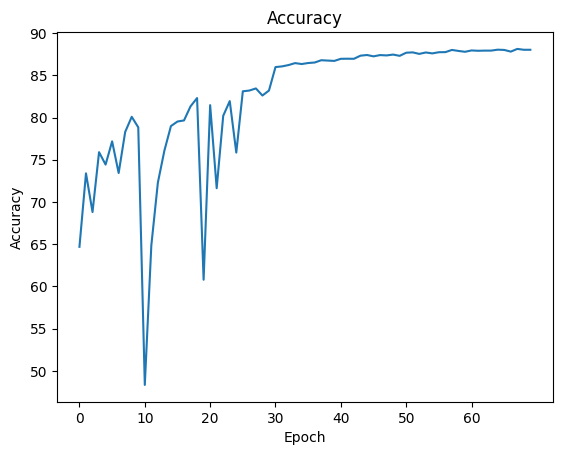

In [9]:
plt.plot(acc_list)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(0,70,10))
plt.ylabel('Accuracy')
plt.show()

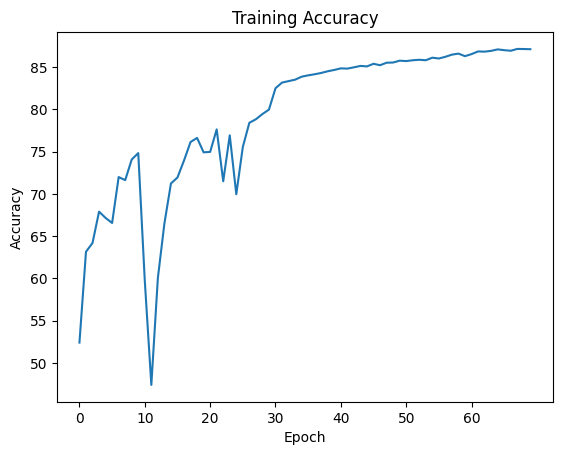

In [10]:
plt.plot(train_acc_list)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(0,70,10))
plt.ylabel('Accuracy')
plt.show()

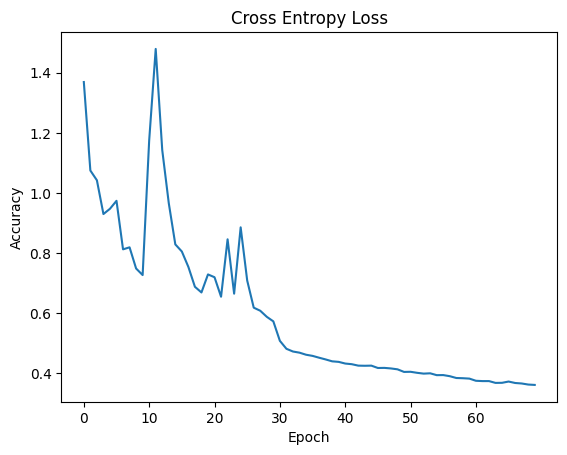

In [11]:
plt.plot(loss_list)
plt.title('Cross Entropy Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(0,70,10))
plt.ylabel('Accuracy')
plt.show()